In [1]:
import numpy as np
import os
from tqdm import tqdm
import cv2
import glob
import datetime
from skimage.io import imread
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import skimage.io as io
import skimage.transform as trans
from skimage import img_as_ubyte
from keras import backend as K

In [2]:
%load_ext tensorboard

In [3]:
from model import *
from utils import *

In [4]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [5]:
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

In [6]:
IMG_WIDTH = IMG_HEIGHT = 256; IMG_CHANNELS = 3
TRAIN_PATH = 'C:/Users/hanus/Desktop/Manipal/semester_2/CNN/project/segmentation/data/neutrophils/train/'
TEST_PATH = 'C:/Users/hanus/Desktop/Manipal/semester_2/CNN/project/segmentation/data/neutrophils/test/'
train_ids = os.listdir(TRAIN_PATH + 'image/')
test_ids = os.listdir(TEST_PATH + 'image/')

In [7]:
# X_train, Y_train, X_test, Y_test = load_data(TRAIN_PATH, TEST_PATH, train_ids, test_ids)

In [8]:
# OneDrive_1_5-16-2021
path_1 = "C:/Users/hanus/Desktop/Manipal/semester_2/CNN/project/unet/unet/dup_data/neutrophils/OneDrive_1_5-16-2021/train/label/"
emp_img_list = []
os.chdir(path_1)

for filename in os.listdir(path_1):
    img = imread(filename)
    if np.sum(img) == 0:
        emp_img_list.append(filename)
print("Number of images without ROI: ", len(emp_img_list))

# non_emp_img_list = []
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
#     if id_ not in emp_img_list:
#         non_emp_img_list.append(id_)

os.chdir('C:/Users/hanus/Desktop/Manipal/semester_2/CNN/project/unet/unet/data')
print('Resizing training images and masks')
X_train = []
Y_train = []
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    if id_ not in emp_img_list:
        img = imread(TRAIN_PATH + '/image/' + id_)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
        X_train.append(img)
        mask = imread(TRAIN_PATH + '/label/' + id_ )
        mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
        Y_train.append((mask[:,:,0] / 255).reshape(256, 256, 1))
        
print('Resizing test images and masks')
X_test = []
Y_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    if id_ not in emp_img_list:
        img1 = imread(TEST_PATH + '/image/' + id_ )
        img1 = cv2.resize(img1, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
        X_test.append(img1)
        mask1 = imread(TEST_PATH  + '/label/' + id_ )
        mask1 = cv2.resize(mask1, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
        Y_test.append((mask1[:,:,0] / 255).reshape(256, 256, 1))
        
X_train = np.array(X_train)/255
Y_train = np.array(Y_train)
X_test = np.array(X_test)/255
Y_test = np.array(Y_test)

  9%|█████████████▍                                                                                                                                       | 34/376 [00:00<00:02, 166.89it/s]

Number of images without ROI:  107
Resizing training images and masks


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 134.54it/s]


Resizing test images and masks


In [9]:
X_train, Y_train = shuffle_data(X_train, Y_train)

In [10]:
# Y_train  = Y_train[:,:,:,0]
# Y_test  = Y_test[:,:,:,0]
# Y_train = Y_train.reshape(-1, 256, 256, 1)
# Y_test = Y_test.reshape(-1, 256, 256, 1)

In [11]:
print("Shapes :\n======\nX_train = {}\nY_train = {}\nX_test  = {}\nY_test  = {}"
      .format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

Shapes :
X_train = (269, 256, 256, 3)
Y_train = (269, 256, 256, 1)
X_test  = (11, 256, 256, 3)
Y_test  = (11, 256, 256, 1)


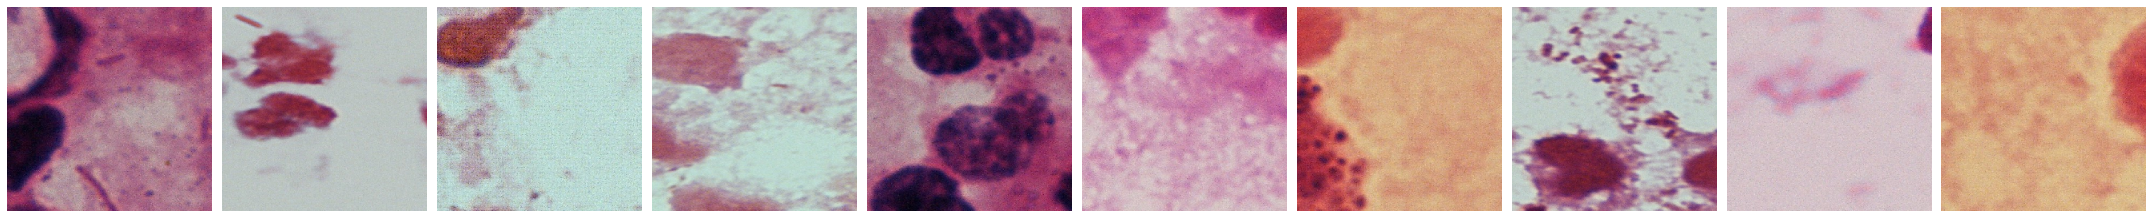

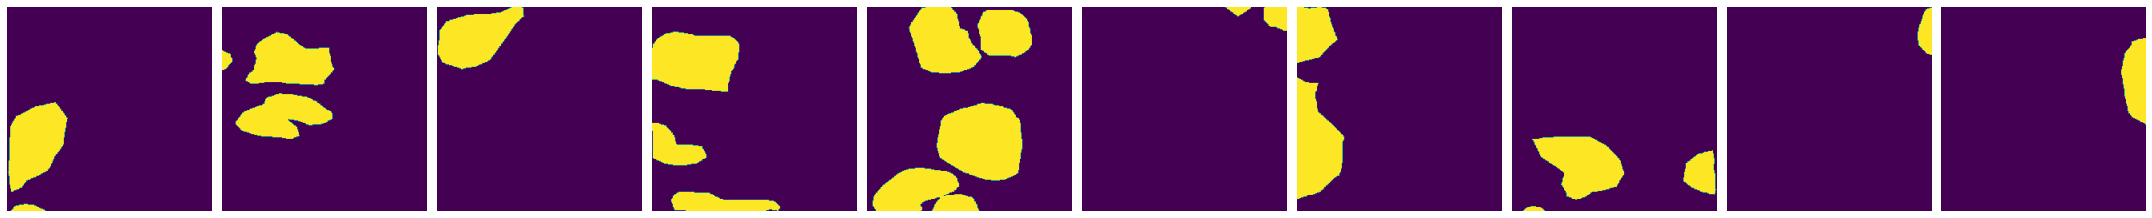

In [12]:
X_train_rot = rotate_image(X_train)
Y_train_rot = rotate_image(Y_train)
plotImages(X_train_rot,10)
plotImages(Y_train_rot,10)

In [14]:
print("Shapes :\n======\nX_train = {}\nY_train = {}\nX_test  = {}\nY_test  = {}"
      .format(X_train_rot.shape, Y_train_rot.shape, X_test.shape, Y_test.shape))

Shapes :
X_train = (269, 256, 256, 3)
Y_train = (269, 256, 256, 1)
X_test  = (11, 256, 256, 3)
Y_test  = (11, 256, 256, 1)


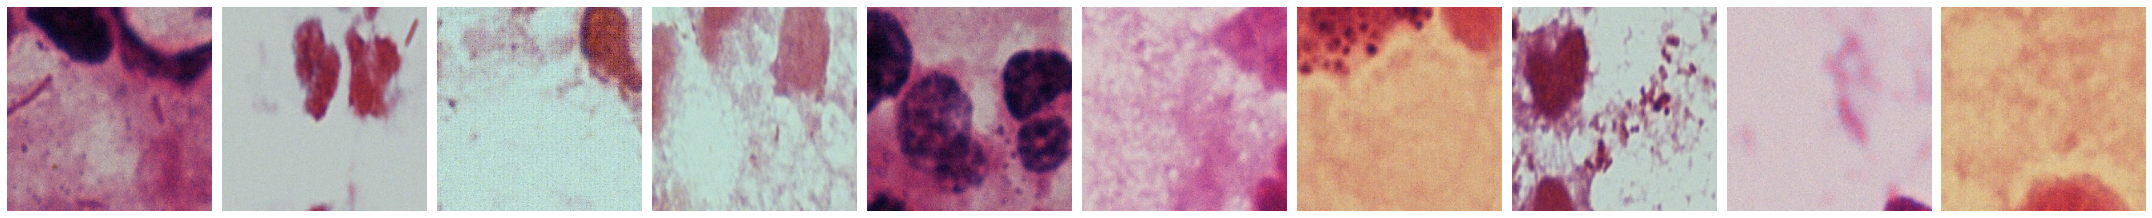

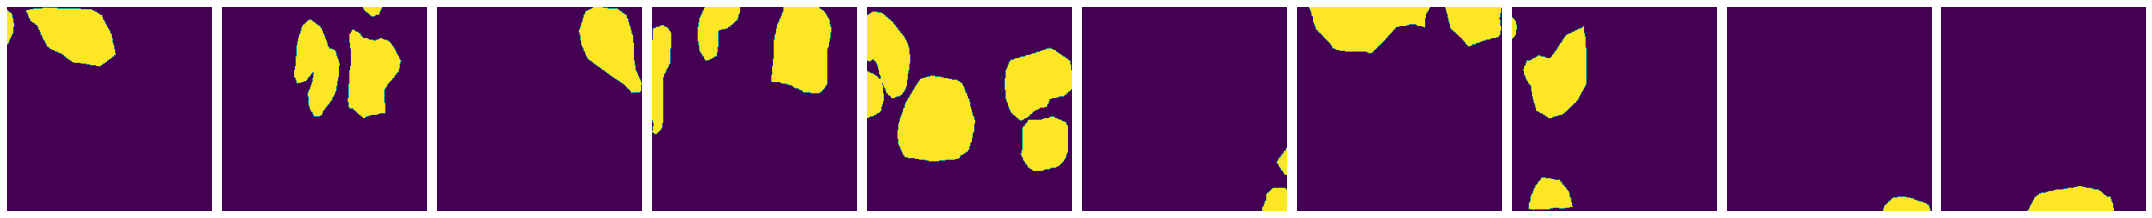

In [13]:
# plot images
plotImages(X_train,10)
plotImages(Y_train,10)

In [18]:
X_train_aug = np.concatenate((X_train, X_train_rot), axis=0)
Y_train_aug = np.concatenate((Y_train, Y_train_rot), axis=0)

In [19]:
X_train_aug, Y_train_aug = shuffle_data(X_train_aug, Y_train_aug)

In [20]:
print("Shapes :\n======\nX_train = {}\nY_train = {}\nX_test  = {}\nY_test  = {}"
      .format(X_train_aug.shape, Y_train_aug.shape, X_test.shape, Y_test.shape))

Shapes :
X_train = (538, 256, 256, 3)
Y_train = (538, 256, 256, 1)
X_test  = (11, 256, 256, 3)
Y_test  = (11, 256, 256, 1)


In [21]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
help(unet_bn)

Help on function unet_bn in module model:

unet_bn(pretrained_weights=None, input_size=(256, 256, 3))



In [23]:
# %tensorboard --logdir logs/fit

In [24]:
##############
# model = small_unet()
model = unet_bn()
##############

In [25]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# checkpointer = tf.keras.callbacks.ModelCheckpoint('unet.h5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(patience = 5, monitor='val_loss')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [earlystopper
             , tensorboard
             # , checkpointer
            ]

results = model.fit(X_train_aug, Y_train_aug
                    , validation_split=0.3
                    , batch_size=4
                    , epochs=100
                    , callbacks=callbacks
                    , verbose=1
                   )

Epoch 1/100
94/94 [==============================] - 57s 433ms/step - loss: -0.1135 - jacard_coef: 0.1135 - val_loss: -0.0539 - val_jacard_coef: 0.0534
Epoch 2/100
94/94 [==============================] - 35s 375ms/step - loss: -0.1461 - jacard_coef: 0.1461 - val_loss: -0.1064 - val_jacard_coef: 0.1075
Epoch 3/100
94/94 [==============================] - 35s 376ms/step - loss: -0.1822 - jacard_coef: 0.1822 - val_loss: -0.1610 - val_jacard_coef: 0.1618
Epoch 4/100
94/94 [==============================] - 35s 376ms/step - loss: -0.2292 - jacard_coef: 0.2292 - val_loss: -0.1639 - val_jacard_coef: 0.1648
Epoch 5/100
94/94 [==============================] - 35s 376ms/step - loss: -0.2619 - jacard_coef: 0.2619 - val_loss: -0.1935 - val_jacard_coef: 0.1949
Epoch 6/100
94/94 [==============================] - 35s 376ms/step - loss: -0.2736 - jacard_coef: 0.2736 - val_loss: -0.2903 - val_jacard_coef: 0.2908
Epoch 7/100
94/94 [==============================] - 35s 377ms/step - loss: -0.2981 - ja

In [26]:
# results.history

In [27]:
model.save_weights("unet_jaccard.h5")
model.load_weights("unet_jaccard.h5")

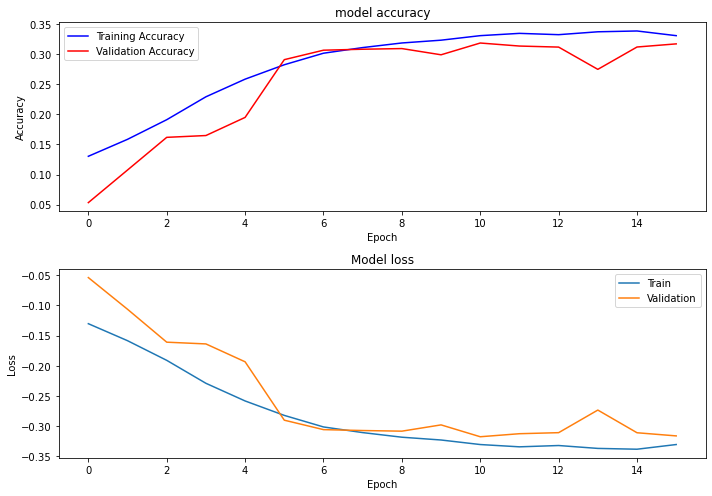

In [28]:
###### for plotting accuracy and loss curve for training and validation set
plt.figure( figsize = (10,7) )
plt.subplot(211)
plt.plot(results.history['jacard_coef'], 'b-')
plt.plot(results.history['val_jacard_coef'], 'r-')
plt.title('model accuracy'); plt.ylabel('Accuracy'); plt.xlabel('Epoch')
plt.legend(['Training Accuracy'
           , 'Validation Accuracy'
           ])
# plt.show()
# fig.savefig("unet_Accuraccy.png")
#summarize history for loss
plt.subplot(212)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss'); plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.legend(['Train'
            , 'Validation'
           ])
plt.tight_layout()
plt.show()
# fig.savefig("unet_Loss.png") 

In [29]:
preds_test = model.predict(X_test, verbose=1)

preds_test_t = (preds_test > 0.075).astype(np.uint8)

1/1 [==============================] - 40s 40s/step


In [28]:
# plotImages(X_test, 10)
# plotImages(Y_test, 10)
# plotImages(preds_test_t, 10)

In [30]:
# for i in range(10):
#     # print(i)
#     plt.figure( figsize=(10,3) )
#     plt.subplot(1,3,1)
#     plt.imshow(X_train[i])
#     plt.subplot(132)
#     plt.imshow(Y_train[i])
#     plt.subplot(133)
#     plt.imshow(preds_test_t[i])
#     plt.show()

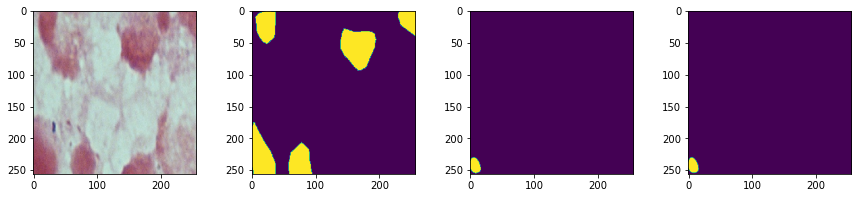

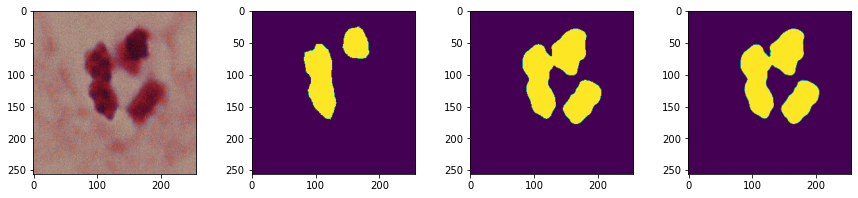

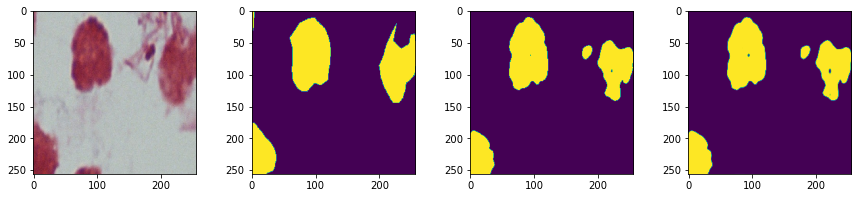

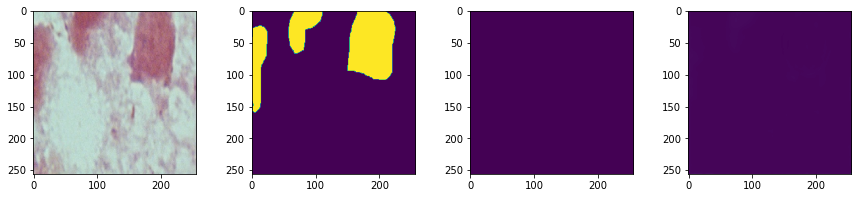

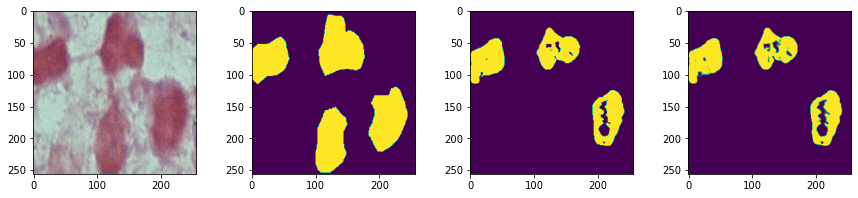

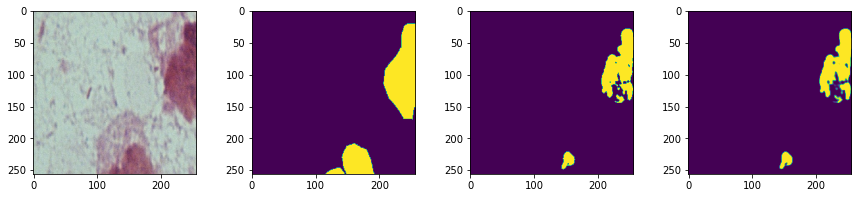

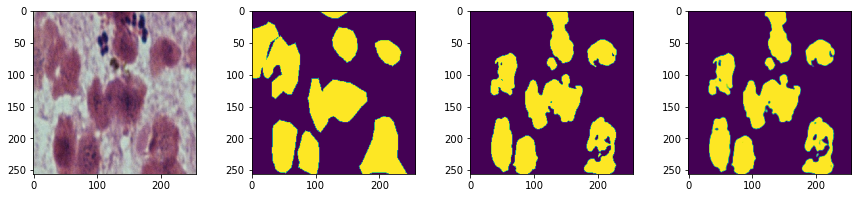

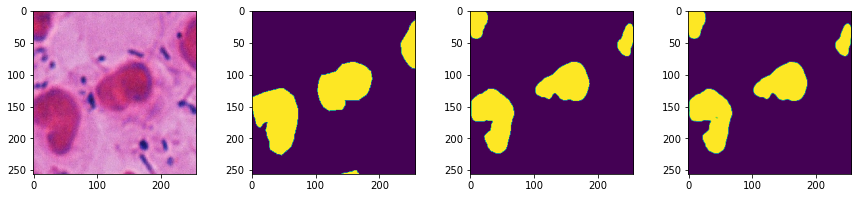

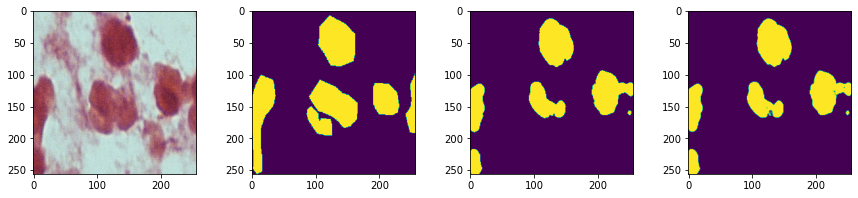

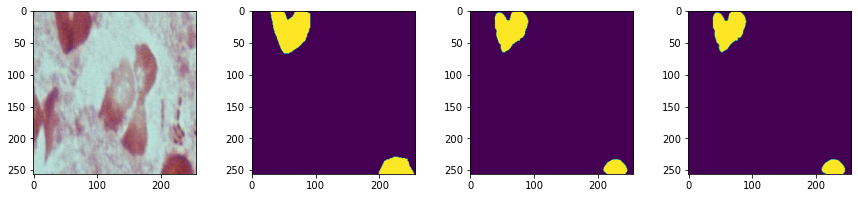

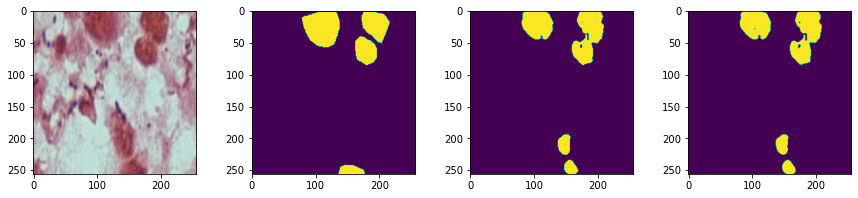

In [31]:
for i in range(len(X_test)):
    # print(i)
    plt.figure( figsize=(15,3) )
    plt.subplot(141)
    plt.imshow(X_test[i])
    plt.subplot(142)
    plt.imshow(Y_test[i])
    plt.subplot(143)
    plt.imshow(preds_test_t[i])
    plt.subplot(144)
    plt.imshow(preds_test[i])
    plt.show()